# Example of Calibration

Import stuff

In [1]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt

from dask.distributed import Client
from dask_jobqueue import SLURMCluster

import nevergrad as ng
from mhpc_project.matsch_b2 import CalibrationModel, Variables, Loss, NGO
from geotopy.utils import date_parser, comparison_plot, ProgressBar, ParametersLogger
from geotopy.measures import KGE

Launch Dask cluster using `dask-jobqueue`

In [2]:
cluster = SLURMCluster()
cluster.adapt(maximum_jobs=128)

client = Client(cluster)

In [3]:
print(cluster.job_script())

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -e /dev/shm/dask-worker-%J.err
#SBATCH -o /dev/shm/dask-worker-%J.out
#SBATCH -p regular2
#SBATCH -n 1
#SBATCH --cpus-per-task=4
#SBATCH --mem=2GB
#SBATCH -t 00:20:00
#SBATCH --hint=nomultithread
#SBATCH --hint=compute_bound
export NUMEXPR_NUM_THREADS=1
export NUMEXPR_MAX_THREADS=1
export OMP_NUM_THREADS=1
export TMPDIR=/dev/shm
/home/scampane/scratch/MHPC-project/.env/bin/python -m distributed.cli.dask_worker tcp://10.6.0.4:44908 --nthreads 4 --memory-limit 2.00GB --name name --nanny --death-timeout 60 --local-directory $TMPDIR --lifetime 18m --lifetime-stagger 1m --interface ib0



Load observations, model, loss function and calibration strategy

In [4]:
observations = pd.read_csv('../data/Matsch B2/obs.csv',
                           na_values=['-9999', '-99.99'],
                           usecols=[0, 7],
                           parse_dates=[0],
                           date_parser=date_parser,
                           index_col=0,
                           squeeze=True)
observations.index.rename('datetime', inplace=True)
model = CalibrationModel('../data/Matsch B2/geotop', run_args={'timeout': 120})
variables = Variables('../data/Matsch B2/variables.csv')
measure = KGE(observations)
loss = Loss(model, variables, measure)
calibration = NGO(loss, budget=4096, num_workers=512)

Evaluate the model and plot the risults

Before optimization loss is 0.7523503598701219


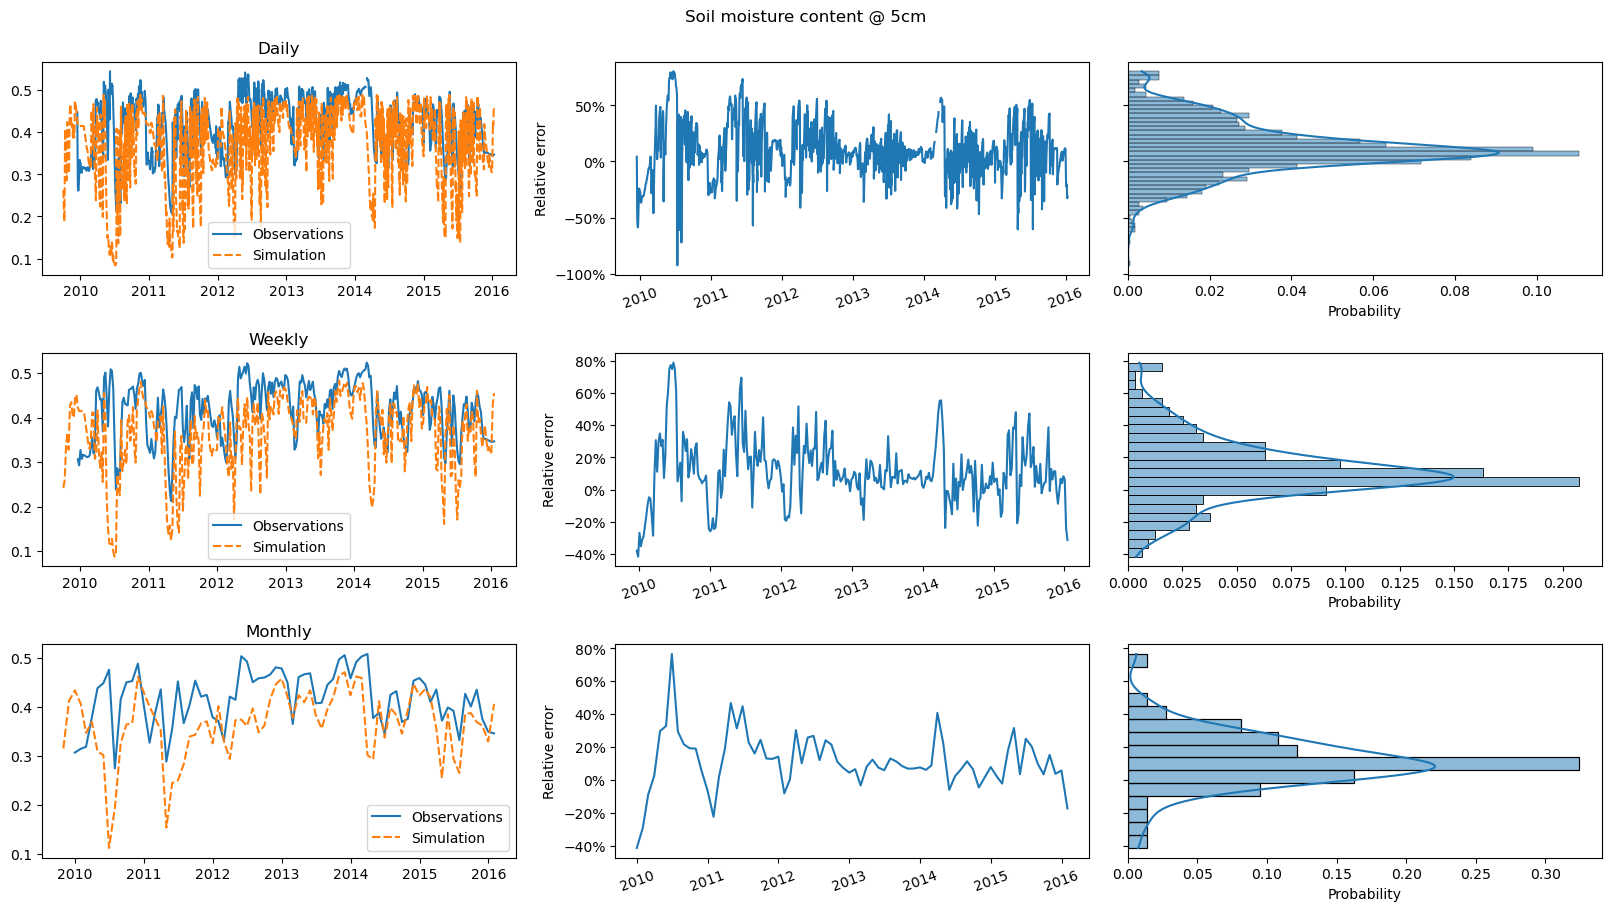

In [5]:
simulation = model()
print(f"Before optimization loss is {measure(simulation)}")
comparison_plot(observations,
                simulation,
                desc='Soil moisture content @ 5cm',
                rel=True)
plt.show()

Run calibration

In [6]:
logger = ParametersLogger(loss.massage)

calibration.optimizer.register_callback('tell', logger)

calibration.optimizer.register_callback('tell', ProgressBar(total=calibration.optimizer.budget))

with warnings.catch_warnings():
    
    warnings.simplefilter("ignore")
    recommendation, best_loss = calibration(executor=client)

(256_w,512)-aCMA-ES (mu_w=131.7,w_1=2%) in dimension 21 (seed=<module 'time' (built-in)>, Mon Nov 23 20:49:04 2020)


Plot results and show table of calibrated values

After optimization loss is 0.49543280856944705


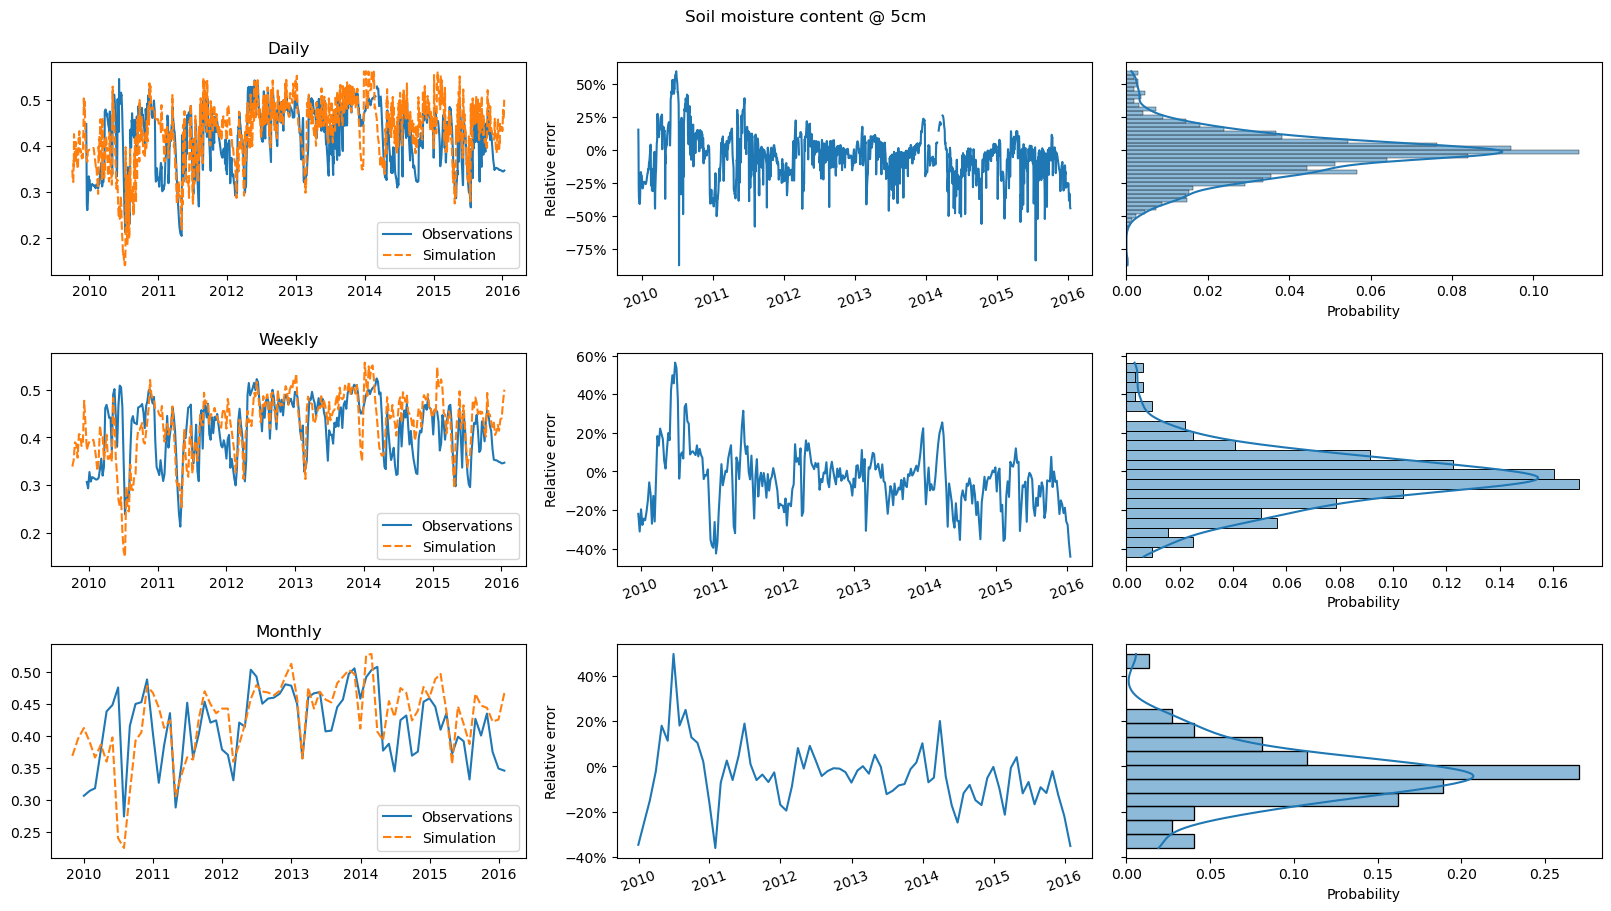

In [7]:
simulation = model(**recommendation)
print(f"After optimization loss is {best_loss}")
comparison_plot(observations,
                simulation,
                desc='Soil moisture content @ 5cm',
                rel=True)
plt.show()

In [8]:
pd.DataFrame.from_dict(recommendation, orient='index', columns=['value'])

,value
NVanGenuchten,1.296519
AlphaVanGenuchten,0.001035
ThetaSat,0.562008
ThetaRes,0.054583
NormalHydrConductivity,0.000701
SoilRoughness,338.577047
LSAI,3.222929
CanopyFraction,0.256034
DecayCoeffCanopy,57.303975
RootDepth,156.372730


pd.DataFrame.from_dict(recommendation, orient='index', columns=['value'])